Multivariate SARIMAX Forecasting Nuitees dans l'hôtellerie Pays de la Loire PDL 2016 
Set "stepwise = true" in auto-arima. Include exogenous variables in training & test datasets
Datasets https://github.com/jinnyto/touristcast/tree/datasets/datasets

In [5]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import pyramid
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
import holidays
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import fbprophet
def seasonal_MASE(truth, forecast, seasonality=1):    
    period = truth.shape[0] # T
    # print(period)
    forecast_errors = np.abs(truth - forecast)
    # print(forecast_errors)
    mean_absolute_forecast_error = np.sum(forecast_errors) / period
    # print(mean_absolute_forecast_error)

    naive_period = truth.shape[0] - seasonality # T - m
    # print(naive_period)
    # print(truth[seasonality:])
    # print(truth[:period - seasonality])
    naive_errors = np.abs(truth[seasonality:] - truth[:period - seasonality])
    mean_absolute_naive_error = np.sum(naive_errors) / naive_period
    
    return mean_absolute_forecast_error / mean_absolute_naive_error
fr_holidays = holidays.France()
fr_holidays.get('2014-01-01')
ld = []
for year in range(2010,2016):
    for date, name in sorted(holidays.FRA(state='FRA', years=year).items()):
        ld.append(date.strftime('%Y-%m-%d'))
ld

['2010-01-01',
 '2010-04-05',
 '2010-05-01',
 '2010-05-08',
 '2010-05-13',
 '2010-05-24',
 '2010-07-14',
 '2010-08-15',
 '2010-11-01',
 '2010-11-11',
 '2010-12-25',
 '2011-01-01',
 '2011-04-25',
 '2011-05-01',
 '2011-05-08',
 '2011-06-02',
 '2011-06-13',
 '2011-07-14',
 '2011-08-15',
 '2011-11-01',
 '2011-11-11',
 '2011-12-25',
 '2012-01-01',
 '2012-04-09',
 '2012-05-01',
 '2012-05-08',
 '2012-05-17',
 '2012-05-28',
 '2012-07-14',
 '2012-08-15',
 '2012-11-01',
 '2012-11-11',
 '2012-12-25',
 '2013-01-01',
 '2013-04-01',
 '2013-05-01',
 '2013-05-08',
 '2013-05-09',
 '2013-05-20',
 '2013-07-14',
 '2013-08-15',
 '2013-11-01',
 '2013-11-11',
 '2013-12-25',
 '2014-01-01',
 '2014-04-21',
 '2014-05-01',
 '2014-05-08',
 '2014-05-29',
 '2014-06-09',
 '2014-07-14',
 '2014-08-15',
 '2014-11-01',
 '2014-11-11',
 '2014-12-25',
 '2015-01-01',
 '2015-04-06',
 '2015-05-01',
 '2015-05-08',
 '2015-05-14',
 '2015-05-25',
 '2015-07-14',
 '2015-08-15',
 '2015-11-01',
 '2015-11-11',
 '2015-12-25']

In [6]:
dn = pd.read_csv('./datasets/nights_2010-2017.csv',parse_dates=['date'], index_col='date',usecols=[*range(1, 15)])

In [7]:
dftrain = dn[(dn.index>='2010-01-01')&(dn.index<'2016-01-01')]
train_nights  = np.array(dftrain.nights_PAC)
y = dftrain['nights_PAC']
dftest = dn[(dn.index>='2016-01-01')&(dn.index<'2017-01-01')]
test_nights = np.array(dftest.nights_PAC)

In [40]:
fb = pd.DataFrame()
fb['ds'] = dftrain.index
fb['y'] = train_nights
holidays = pd.DataFrame({  
  'holiday': 'france',
  'ds': pd.to_datetime(ld),
})
fb_prophet = fbprophet.Prophet(yearly_seasonality=True, seasonality_mode='multiplicative',seasonality_prior_scale=0.04, changepoint_prior_scale=0.01, holidays=holidays, holidays_prior_scale=0.01)
fb_prophet.fit(fb)
fb_forecast = fb_prophet.make_future_dataframe(periods=12, freq='M')
fb_forecast = fb_prophet.predict(fb_forecast)
tc_future_forecast= np.array(fb_forecast.tail(12).yhat)
mae = mean_absolute_error(test_nights, tc_future_forecast)
print('MAE: %f' % mae)
mse = mean_squared_error(test_nights, tc_future_forecast)
print('MSE: %f' % mse)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)
smase = seasonal_MASE(test_nights,tc_future_forecast)
print('MASE: %f' % smase)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/aa/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


MAE: 75.181301
MSE: 10858.892305
RMSE: 104.206009
MASE: 0.196511


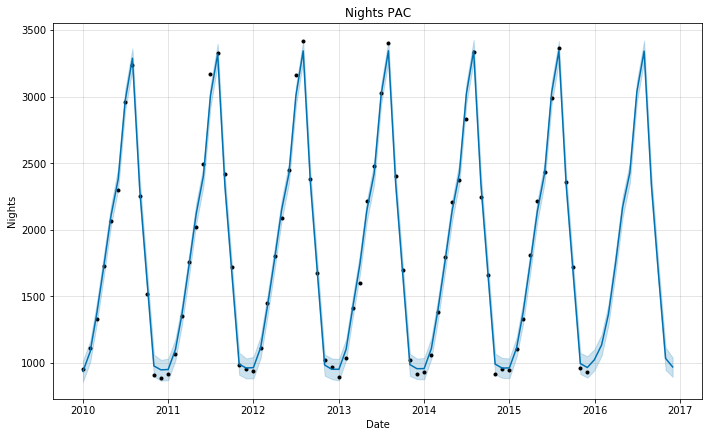

In [41]:
fb_prophet.plot(fb_forecast, xlabel = 'Date', ylabel = 'Nights')
plt.title('Nights PAC');

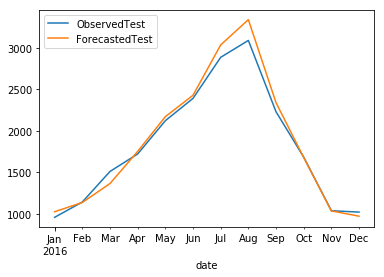

In [42]:
tc_future_forecast= np.array(fb_forecast.tail(12).yhat)
tc_dff = pd.DataFrame(tc_future_forecast, index = dftest.index)
pd.concat([dftest.nights_PAC,tc_dff],axis=1).plot()
L=plt.legend()
L.get_texts()[0].set_text('ObservedTest')
L.get_texts()[1].set_text('ForecastedTest')

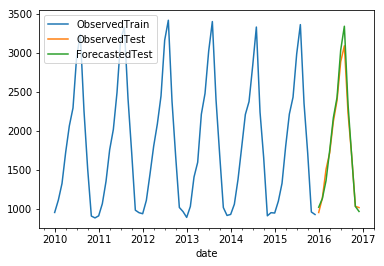

In [44]:
pd.concat([dftrain.nights_PAC,dftest.nights_PAC,tc_dff],axis=1).plot()
L=plt.legend()
L.get_texts()[0].set_text('ObservedTrain')
L.get_texts()[1].set_text('ObservedTest')
L.get_texts()[2].set_text('ForecastedTest')
plt.show()